# Compute Sequence weights for SignalP dataset
https://www.nature.com/articles/s41592-018-0138-4  
https://arxiv.org/pdf/1211.1281.pdf

## How to get distances
Pott Model: Distance: _fraction of conserved positions (i.e., identical amino acids)_  
Deep Model: Distance: Hamming distance  

→ I cannot calculate those from sequences, but only from MSA, as distance metrics require equal lengths. We never produce a MSA during data selection, so we need to do something else.

We need distances from a multiple sequence alignment. Let's use Famsa, because it's fast and Magnús recommended it also for Graph-Part. (https://www.nature.com/articles/srep33964)   

The distance is defined as  
![](https://media.springernature.com/lw226/springer-static/image/art%3A10.1038%2Fsrep33964/MediaObjects/41598_2016_Article_BFsrep33964_Equ1_HTML.gif)  
with  
![](https://media.springernature.com/lw293/springer-static/image/art%3A10.1038%2Fsrep33964/MediaObjects/41598_2016_Article_BFsrep33964_Equ2_HTML.gif)

In [5]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../../')

In [6]:
#just to check dimensonalities of everything
from train_scripts.utils.signalp_dataset import parse_threeline_fasta
headers, sequences, labels =parse_threeline_fasta('../signalp_5_data/train_set.fasta')

In [8]:
from tqdm.notebook import tqdm
def parse_famsa_distance_matrix(filename):
    '''Famsa distance matrix is just lower triangle to save memory. This does not work with standard csv reading methods, need to load
    line by line, convert to array and pad to full matrix size.'''
    with open(filename, 'r') as f:
        lines = f.readlines()
    padded_lines = []
    identifiers = []
    total_len = len(lines)
    for l in tqdm(lines):
        l_splitted = l.rstrip().split(',')
        identifiers.append(l_splitted[0])
        #convert
        l_dists = [float(x) for x in l_splitted[1:-1]] #first is ID, last is ','
        l_dists = np.array(l_dists)
        pad_len = total_len - l_dists.shape[0]
        padded_line = np.pad(l_dists, (0, pad_len), 'constant', constant_values=(0))
        padded_lines.append(padded_line)

    dist_matrix_lower = np.array(padded_lines)
    
    return dist_matrix_lower, identifiers

In [9]:
dist_mat_lower, identifiers = parse_famsa_distance_matrix('train_set_dists.csv')
dist_mat = dist_mat_lower + dist_mat_lower.T

In [190]:
all_dists = dist_mat_lower[np.nonzero(dist_mat_lower)]

print(np.median(all_dists))
print(np.mean(all_dists))
print(np.max(all_dists))
print(np.min(all_dists))

3.83333
3.995669106764454
138.0
0.0289855


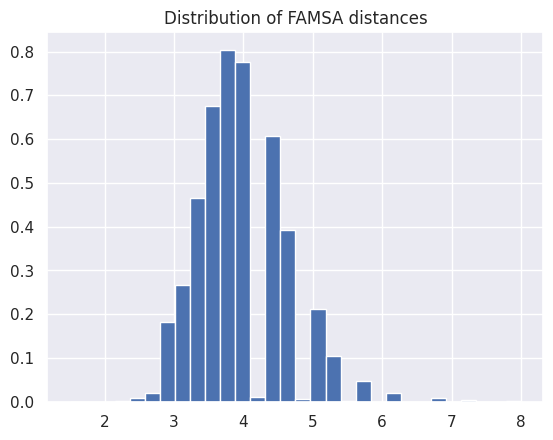

In [208]:
plt.hist(all_dists, range = (1.5, 8), bins =30, density=True)
plt.title('Distribution of FAMSA distances')
plt.show()

### Proposed approach:
- Set a threshold
- Count number of sequences within that threshold
- Sequence weight = 1/count

__I don't like that I have to pick a threshold here. But also don't see a way to do it without one, things like mean distance make no sense.__

In [142]:
thresholded_weights = []
threshold_list = np.arange(0.5,2.7,0.125)
for threshold in threshold_list:
    threshold_counts = (dist_mat <= threshold).sum(axis = 1)
    weights = 1/threshold_counts
    thresholded_weights.append(weights)

In [143]:
plotting_df = pd.DataFrame(thresholded_weights, index =  [str(x) for x in threshold_list])
plotting_df = plotting_df.reset_index().melt(id_vars = 'index')

Text(0.5, 1.0, 'Effect of distance threshold')

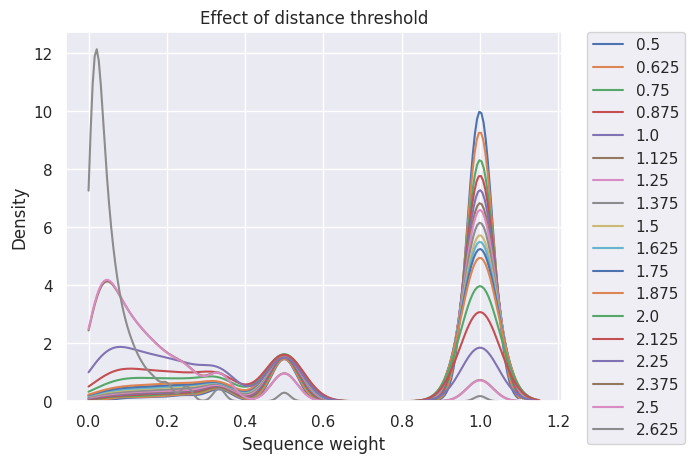

In [151]:
sns.set(style="darkgrid")

for idx in plotting_df['index'].unique():
    sns.kdeplot(plotting_df[plotting_df['index'] == idx]['value'], clip = [0,None])
    
plt.legend(plotting_df['index'].unique(), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlabel('Sequence weight')
#plt.legend(plotting_df['index'].unique())
plt.title('Effect of distance threshold')

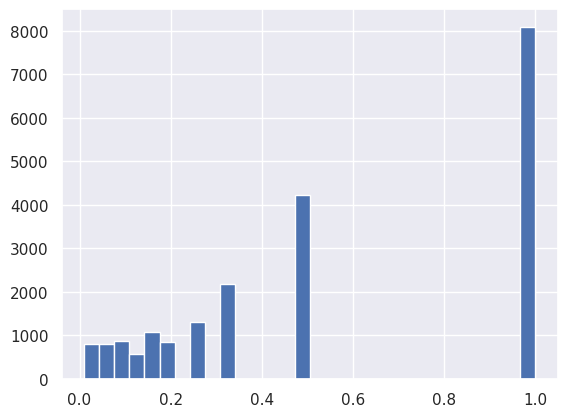

In [213]:
plt.hist(plotting_df[plotting_df['index'] == '2.125']['value'], bins = 30)
plt.show()

Most sequences retain a weight of 1, but a significant amount gets a weight of 0.5 - meaning there are two sequences that are similar. This seems to be a reasonable choice. Further increasing the threshold produces too many weights close to 0, practically discarding sequences from the training data.

In [203]:
threshold_counts = (dist_mat <= 2.125).sum(axis = 1)
weights = 1/threshold_counts
df_out = pd.DataFrame(weights,index = [x.lstrip('>').split('|')[0] for x in identifiers])

In [207]:
df_out.to_csv('train_set_weights_famsa_2_125.csv')

#### Alternative plot: save for some other time, when I might need it. Plots above are better for interpretation.

/mnt/c/Users/felix/Coding/protein_modeling/testenv/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/mnt/c/Users/felix/Coding/protein_modeling/testenv/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


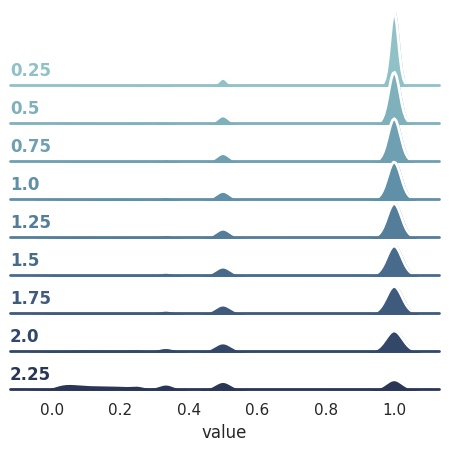

In [129]:
#ridge plot
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(plotting_df, row="index", hue="index", aspect=10, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "value",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "value")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)